# E28. 이미지 이상탐지모델 (GAN)

In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

from tensorflow.keras.datasets import cifar10

## Anomaly Detection with GAN
* AnoGAN: GAN을 이용해 Anomaly 데이터가 부족한 상황에서도 unsupervised 방식으로 Anomaly Detection 모델 구현이 가능하다는 아이디어
    * https://arxiv.org/pdf/1703.05921.pdf
        - 학습 데이터로 Anomal하지 않은 정상 (normal) 데이터만 사용
        - GAN의 원리에 의해 Discriminator는 정상적인 이미지와 (Generator가 만들어낸) 가짜 이미지를 잘 구분하게 될 것이고,
        - Generator는 그런 Discriminator를 속이기 위해 정상 데이터같은 이미지를 만들어낼 것
        - AnoGAN "잘 훈련된 GAN의 Generator $x = G(z)$ 란, latent variable z와 이미지 x 사이의 어떤 맵핑을 나타내는 함수가 아닐까? 그렇다면 Normal 데이터를 잘 만들어낼 수 있는 z의 영역을 (z를 수없이 샘플링해 가면서) 더듬더듬 찾아내면 논문의 Fig.2. (b) 와 같은 윤곽이 얻어지게 될 수 있지 않을까?"
        - 와 같은 생각에서 두 가지 추가적인 loss를 정의
            - Residual Loss: $\mathcal{L}_R(z_{\gamma}) = \sum |x - G(z_{\gamma})|$
            - Discrimination Loss: $\mathcal{L}_D(z_{\gamma}) = \sum |f(x) - f(G(z_{\gamma}))|$
            - (f: discriminator의 중간 레이어)
        - 최종적으로, 다음 loss를 최소화하도록 (파라미터를 찾는 게 아니라) z를 찾아나가는 것: $\mathcal{L}(z_{\gamma}) = (1-\lambda)\mathcal{L}_R(z_{\gamma}) + \lambda\mathcal{L}_D(z_{\gamma})$
* EGBAD (feat. by BiGAN)
    - AnoGAN의 단점: z의 latent space를 직접 찾겠다는 것은 많은 계산량을 요구
    - latent space를 직접 모델링하는 형태의 GAN 모델이 존재: BiGAN
    - BiGAN에는 Generator와 Discriminator 이외에도 G의 역함수 구실을 하는 E 네트워크가 존재 (=Encoder)
    - 따라서, Discriminator는 x와 G(z) 를 비교하는 게 아니라 (x, E(x)) 와 (G(z), z) 를 비교하는 형태로 구성됨

## GANomaly
* https://arxiv.org/pdf/1805.06725.pdf
    - AnoGAN과 BiGAN Encoder에서 기본 아이디어를 가져와 잘 결합한 뒤, Encoder-Decoder-Encoder 구조의 네트워크로 다시 묶어냄
    - GANomaly의 Generator는 일반적인 GAN과 달리 Encoder-Decoder 구조이며, 입력값이 (latent variable) z가 아니라 이미지 x
    - 다음 3가지 loss를 최소화하는 형태로 학습 진행
        - Adversarial Loss: $\mathcal{L}_{adv} = \mathbb{E}_{x \sim p_X}\lVert f(x) - \mathbb{E}_{x \sim p_X}f(F(x)) \rVert_2$
        - Contextual Loss: $\mathcal{L}_{con} = \mathbb{E}_{x \sim p_X}\lVert x - G(x) \rVert_1$
        - Encoder Loss: $ \mathcal{L}_{enc} = \mathbb{E}_{x \sim p_X}\lVert G_E(x) - E(G(x)) \rVert_2$
    - 전체적인 loss: $\mathcal{L} = w_{adv}\mathcal{L}_{adv} + w_{con}\mathcal{L}_{con} + w_{enc}\mathcal{L}_{enc}$

## Skip-GANomaly
* https://arxiv.org/pdf/1901.08954.pdf

## 데이터셋 구성
* Fashion-MNIST: https://github.com/zalandoresearch/fashion-mnist
    - 1채널 grayscale 데이터셋이므로 그냥은 convolution 연산이 되지 않음
        - 채널방향 차원이 하나 늘어나도록 reshape하는 과정 필요
    - UNet 구조의 활용을 위해서 기존의 28 X 28 사이즈의 Fashion-MNIST 데이터 이미지를 32 X 32 로 패딩처리해 줄 필요

In [ ]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

from PIL import Image

# Fashion MNIST padding to 32 X 32
train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')     
train_data_32[:, 2:30, 2:30] = train_data
test_data_32[:, 2:30, 2:30] = test_data

# 1channel data reshape
train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 1).astype('float32')
test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 1).astype('float32')

print(train_data.shape)
print(test_data.shape)

In [ ]:
# 데이터 확인
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i].reshape(32, 32), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [ ]:
# 이상 데이터 (8번, bag) 제외
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 8:   # Bag:8
            new_t_labels.append([0])  # Bag을 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [ ]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

* 60000건의 훈련데이터 중 6000건이 제외되어 10000건의 테스트 데이터에 추가

In [ ]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [ ]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

In [ ]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [ ]:
print(train_data.shape)
print(test_data.shape)

In [ ]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

In [ ]:
# 데이터셋이 정확하게 구성되었는지 검증
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

In [ ]:
# 데이터셋 구성
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# 라벨 검증
# 훈련 데이터셋에는 라벨이 1인 데이터만 존재하고, 테스트 데이터에는 0과 1이 섞여 있어야 합니다.

for data, label in train_dataset.take(1): # 훈련 데이터셋
    print(label)

In [ ]:
for data, label in test_dataset.take(1): # 테스트 데이터셋
    print(label)

## 모델과 loss 함수 구성

### Generator
* UNet 구조를 따릅니다.

In [2]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [3]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [4]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

### Discriminator
* Generator처럼 Conv_block을 활용하며, 최종적으로 sigmoid를 거쳐 0~1 사이의 숫자를 리턴합니다.

In [5]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

### Generator와 Discriminator를 합해 전체 모델 구성

In [ ]:
generator = Generator(num_output_channel=1)
discriminator = Discriminator()

### loss 함수
* GAN 모델의 핵심은 loss 함수의 구성 방법에 달려 있습니다.
* Skip-GANomaly는 이전 모델들과 달리 일반적인 GAN의 학습 절차와 같은 형태의 Loss 구성이 진행됩니다.

In [7]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [8]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    # return tf.cast(total_dis_loss, tf.float32)
    return total_dis_loss

In [9]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    # return tf.cast(total_gen_loss, tf.float32)
    return total_gen_loss

In [10]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## 모델 학습과 평가
### train

In [ ]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [ ]:
checkpoint_path = 'ganomaly_skip_no_norm/ckpt'

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# 1시간 이상 소요

max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

### evaluation

In [ ]:
# 학습 도중 저장된 체크포인트 활용
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [ ]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [ ]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

In [ ]:
# 라벨에 따라 anomaly score의 분포가 다르게 나타나는지 검증
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

In [ ]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

In [ ]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

## 프로젝트: 개구리는 안돼요 (CIFAR-10)
* 이상감지용 데이터셋 구축 (개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함)
* Skip-GANomaly 모델의 구현
* 모델의 학습과 검증
* 검증 결과의 시각화 (정상-이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이삼감지율 계산, 감지 성공/실패사례 시각화 포함)

In [11]:
# CIFAR-10 데이터셋 로드
# https://gruuuuu.github.io/machine-learning/cifar10-cnn/

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print ("Training data:")
print ("Number of examples: ", X_train.shape[0])
print ("Number of channels:",X_train.shape[3]) 
print ("Image size:", X_train.shape[1], X_train.shape[2])
print
print ("Test data:")
print ("Number of examples:", X_test.shape[0])
print ("Number of channels:", X_test.shape[3])
print ("Image size:", X_test.shape[1], X_test.shape[2]) 

Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32


In [12]:
print(y_train[0])

[6]


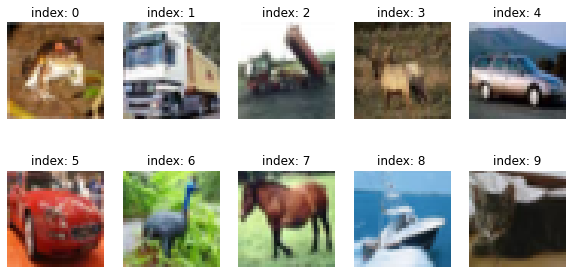

In [13]:
# 데이터 확인
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [14]:
# 0번이 개구리임을 확인. 개구리 제외
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 0:
            new_t_labels.append([0]) # 0 (frog) 는 이상치
        else:
            new_t_labels.append([1]) # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [15]:
bol_train_labels = set_labels(y_train)
bol_test_labels = set_labels(y_test)

In [16]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []

for data, label in zip(X_train, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [17]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [18]:
train_data = normal_data # 개구리 제외한 데이터를 training data로
bol_train_labels = normal_labels
test_data = tf.concat([X_test, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [19]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [20]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


In [21]:
# 데이터셋이 정확하게 구성되었는지 검증
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [22]:
# 데이터셋 구성
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [23]:
# 라벨 검증
# 훈련 데이터셋에는 라벨이 1인 데이터만 존재하고, 테스트 데이터에는 0과 1이 섞여 있어야 합니다.

for data, label in train_dataset.take(1): # 훈련 데이터셋
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [24]:
for data, label in test_dataset.take(1): # 테스트 데이터셋
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


### 모델 구성
* 위 실습에서 구성한 모델 활용

In [6]:
# generator 채널 수만 변경
generator = Generator(num_output_channel=3)
discriminator = Discriminator()

### train

In [25]:
@tf.function()
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [26]:
checkpoint_path = 'ganomaly_skip_no_norm/cifar10/ckpt'

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
max_epochs = 100
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(tf.cast(images, tf.float32)) # warning 제거 위해 임의로 자료형 cast함
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 4981.8095703125, 	 Total Dis Loss : 0.6775773167610168
Steps : 200, 	 Total Gen Loss : 3739.433837890625, 	 Total Dis Loss : 0.4182469844818115
Steps : 300, 	 Total Gen Loss : 3712.87744140625, 	 Total Dis Loss : 0.2312907874584198
Steps : 400, 	 Total Gen Loss : 3441.894775390625, 	 Total Dis Loss : 0.1678539216518402
Steps : 500, 	 Total Gen Loss : 3319.87353515625, 	 Total Dis Loss : 0.0710604265332222
Steps : 600, 	 Total Gen Loss : 4439.92724609375, 	 Total Dis Loss : 0.063031867146492
Steps : 700, 	 Total Gen Loss : 4388.45849609375, 	 Total Dis Loss : 0.030544094741344452
Steps : 800, 	 Total Gen Loss : 3301.0322265625, 	 Total Dis Loss : 0.02501210756599903
Steps : 900, 	 Total Gen Loss : 3492.27978515625, 	 Total Dis Loss : 0.017471566796302795
Steps : 1000, 	 Total Gen Loss : 3251.72509765625, 	 Total Dis Loss : 0.010676702484488487
Steps : 1100, 	 Total Gen Loss : 3598.67724609375, 	 Total Dis Loss : 0.23388394713401794
Steps : 1200, 	 Total G

Steps : 9100, 	 Total Gen Loss : 3518.2099609375, 	 Total Dis Loss : 0.0006506233476102352
Steps : 9200, 	 Total Gen Loss : 3674.73583984375, 	 Total Dis Loss : 0.0005094291409477592
Steps : 9300, 	 Total Gen Loss : 3639.770263671875, 	 Total Dis Loss : 0.00024200264306273311
Steps : 9400, 	 Total Gen Loss : 3233.017578125, 	 Total Dis Loss : 0.0004430263943504542
Steps : 9500, 	 Total Gen Loss : 3511.532470703125, 	 Total Dis Loss : 0.0006146423984318972
Steps : 9600, 	 Total Gen Loss : 3541.77392578125, 	 Total Dis Loss : 0.00016708702605683357
Steps : 9700, 	 Total Gen Loss : 3598.787109375, 	 Total Dis Loss : 0.0005376410554163158
Steps : 9800, 	 Total Gen Loss : 3736.106201171875, 	 Total Dis Loss : 0.00025273801293224096
Steps : 9900, 	 Total Gen Loss : 3357.651123046875, 	 Total Dis Loss : 0.022952113300561905
Steps : 10000, 	 Total Gen Loss : 3573.2099609375, 	 Total Dis Loss : 0.00039164110785350204
Steps : 10100, 	 Total Gen Loss : 3714.958251953125, 	 Total Dis Loss : 0.0010

Steps : 17900, 	 Total Gen Loss : 3239.28564453125, 	 Total Dis Loss : 0.0005552556249313056
Steps : 18000, 	 Total Gen Loss : 3744.7080078125, 	 Total Dis Loss : 0.0006752283661626279
Steps : 18100, 	 Total Gen Loss : 3957.933837890625, 	 Total Dis Loss : 0.00044839721522293985
Steps : 18200, 	 Total Gen Loss : 4073.938720703125, 	 Total Dis Loss : 0.00031129096169024706
Steps : 18300, 	 Total Gen Loss : 3534.225341796875, 	 Total Dis Loss : 0.0003090713871642947
Steps : 18400, 	 Total Gen Loss : 3918.33203125, 	 Total Dis Loss : 0.00013029832916799933
Steps : 18500, 	 Total Gen Loss : 3557.644775390625, 	 Total Dis Loss : 0.0003889047948177904
Steps : 18600, 	 Total Gen Loss : 3588.73388671875, 	 Total Dis Loss : 8.848650759318843e-05
Steps : 18700, 	 Total Gen Loss : 3106.4599609375, 	 Total Dis Loss : 0.000424671801738441
Steps : 18800, 	 Total Gen Loss : 3170.353271484375, 	 Total Dis Loss : 0.00047199393156915903
Steps : 18900, 	 Total Gen Loss : 4078.21337890625, 	 Total Dis Los

Steps : 26700, 	 Total Gen Loss : 3421.54345703125, 	 Total Dis Loss : 0.00011101391282863915
Steps : 26800, 	 Total Gen Loss : 3515.4697265625, 	 Total Dis Loss : 0.00024553644470870495
Steps : 26900, 	 Total Gen Loss : 3642.657470703125, 	 Total Dis Loss : 0.0005667299265041947
Steps : 27000, 	 Total Gen Loss : 3437.370849609375, 	 Total Dis Loss : 0.000364270294085145
Steps : 27100, 	 Total Gen Loss : 3534.746826171875, 	 Total Dis Loss : 0.00010940876381937414
Steps : 27200, 	 Total Gen Loss : 3896.02392578125, 	 Total Dis Loss : 0.00026171570061706007
Steps : 27300, 	 Total Gen Loss : 3127.933837890625, 	 Total Dis Loss : 0.00011620558507274836
Steps : 27400, 	 Total Gen Loss : 3736.396484375, 	 Total Dis Loss : 9.279981895815581e-05
Steps : 27500, 	 Total Gen Loss : 3882.33740234375, 	 Total Dis Loss : 0.00035009998828172684
Steps : 27600, 	 Total Gen Loss : 3676.748291015625, 	 Total Dis Loss : 0.00010094272147398442
Steps : 27700, 	 Total Gen Loss : 3494.990478515625, 	 Total D

Steps : 35500, 	 Total Gen Loss : 3191.16357421875, 	 Total Dis Loss : 0.00011339296906953678
Steps : 35600, 	 Total Gen Loss : 3074.029541015625, 	 Total Dis Loss : 0.0001773591066012159
Steps : 35700, 	 Total Gen Loss : 3338.826171875, 	 Total Dis Loss : 2.3188316845335066e-05
Steps : 35800, 	 Total Gen Loss : 3611.132080078125, 	 Total Dis Loss : 0.012384051457047462
Steps : 35900, 	 Total Gen Loss : 3206.59765625, 	 Total Dis Loss : 0.00012530021194834262
Steps : 36000, 	 Total Gen Loss : 3481.4189453125, 	 Total Dis Loss : 0.0007750854128971696
Steps : 36100, 	 Total Gen Loss : 3786.572998046875, 	 Total Dis Loss : 7.325624756049365e-05
Steps : 36200, 	 Total Gen Loss : 3551.41455078125, 	 Total Dis Loss : 6.301884423010051e-05
Steps : 36300, 	 Total Gen Loss : 3716.925048828125, 	 Total Dis Loss : 7.620178075740114e-05
Steps : 36400, 	 Total Gen Loss : 3594.37353515625, 	 Total Dis Loss : 0.0008048240561038256
Steps : 36500, 	 Total Gen Loss : 3365.883544921875, 	 Total Dis Loss 

Steps : 44300, 	 Total Gen Loss : 3210.724365234375, 	 Total Dis Loss : 1.2070908269379288e-05
Steps : 44400, 	 Total Gen Loss : 3254.631103515625, 	 Total Dis Loss : 9.385468729306012e-06
Steps : 44500, 	 Total Gen Loss : 3400.48095703125, 	 Total Dis Loss : 5.149648495716974e-05
Steps : 44600, 	 Total Gen Loss : 3429.75244140625, 	 Total Dis Loss : 1.2355345461401157e-05
Steps : 44700, 	 Total Gen Loss : 3070.5947265625, 	 Total Dis Loss : 2.247941847599577e-05
Steps : 44800, 	 Total Gen Loss : 3986.242919921875, 	 Total Dis Loss : 0.0002571761142462492
Steps : 44900, 	 Total Gen Loss : 3881.951416015625, 	 Total Dis Loss : 2.9438873752951622e-05
Steps : 45000, 	 Total Gen Loss : 3555.351318359375, 	 Total Dis Loss : 3.423765883781016e-05
Time for epoch 8 is 74.81211018562317 sec
Steps : 45100, 	 Total Gen Loss : 3646.308349609375, 	 Total Dis Loss : 1.566576975164935e-05
Steps : 45200, 	 Total Gen Loss : 3687.973388671875, 	 Total Dis Loss : 8.243112097261474e-05
Steps : 45300, 	 To

Steps : 53100, 	 Total Gen Loss : 4073.001708984375, 	 Total Dis Loss : 4.442262070369907e-05
Steps : 53200, 	 Total Gen Loss : 3847.766357421875, 	 Total Dis Loss : 5.796761251986027e-05
Steps : 53300, 	 Total Gen Loss : 3525.023681640625, 	 Total Dis Loss : 4.5363489334704354e-05
Steps : 53400, 	 Total Gen Loss : 3319.4326171875, 	 Total Dis Loss : 1.9475755834719166e-05
Steps : 53500, 	 Total Gen Loss : 3038.24169921875, 	 Total Dis Loss : 1.3666084669239353e-05
Steps : 53600, 	 Total Gen Loss : 3751.68798828125, 	 Total Dis Loss : 3.745697904378176e-05
Steps : 53700, 	 Total Gen Loss : 3872.3271484375, 	 Total Dis Loss : 4.8721205530455336e-05
Steps : 53800, 	 Total Gen Loss : 3415.718017578125, 	 Total Dis Loss : 3.881604425259866e-05
Steps : 53900, 	 Total Gen Loss : 3773.1171875, 	 Total Dis Loss : 2.4108065190375783e-05
Steps : 54000, 	 Total Gen Loss : 3948.27001953125, 	 Total Dis Loss : 2.568172749306541e-05
Steps : 54100, 	 Total Gen Loss : 3947.60693359375, 	 Total Dis Los

Time for epoch 11 is 74.97103595733643 sec
Steps : 61900, 	 Total Gen Loss : 3507.174072265625, 	 Total Dis Loss : 2.021022555709351e-05
Steps : 62000, 	 Total Gen Loss : 3659.32958984375, 	 Total Dis Loss : 9.745895113155711e-06
Steps : 62100, 	 Total Gen Loss : 3377.12109375, 	 Total Dis Loss : 3.0461413189186715e-05
Steps : 62200, 	 Total Gen Loss : 4718.05078125, 	 Total Dis Loss : 1.0354222467867658e-05
Steps : 62300, 	 Total Gen Loss : 3923.691162109375, 	 Total Dis Loss : 3.165995076415129e-05
Steps : 62400, 	 Total Gen Loss : 3576.2177734375, 	 Total Dis Loss : 7.182310946518555e-05
Steps : 62500, 	 Total Gen Loss : 3792.73779296875, 	 Total Dis Loss : 2.8995815227972344e-05
Steps : 62600, 	 Total Gen Loss : 3583.947998046875, 	 Total Dis Loss : 2.29397392104147e-05
Steps : 62700, 	 Total Gen Loss : 3540.760498046875, 	 Total Dis Loss : 4.1351573599968106e-05
Steps : 62800, 	 Total Gen Loss : 3556.51953125, 	 Total Dis Loss : 4.4583350245375186e-05
Steps : 62900, 	 Total Gen Lo

Steps : 70700, 	 Total Gen Loss : 3447.673095703125, 	 Total Dis Loss : 8.374858589377254e-05
Steps : 70800, 	 Total Gen Loss : 2993.7470703125, 	 Total Dis Loss : 5.199558290769346e-05
Steps : 70900, 	 Total Gen Loss : 3800.5146484375, 	 Total Dis Loss : 4.434376023709774e-05
Steps : 71000, 	 Total Gen Loss : 3746.093994140625, 	 Total Dis Loss : 4.20420037698932e-05
Steps : 71100, 	 Total Gen Loss : 3840.1064453125, 	 Total Dis Loss : 2.3193682864075527e-05
Steps : 71200, 	 Total Gen Loss : 3707.3974609375, 	 Total Dis Loss : 3.5191362258046865e-05
Steps : 71300, 	 Total Gen Loss : 2955.763427734375, 	 Total Dis Loss : 8.063498171395622e-06
Steps : 71400, 	 Total Gen Loss : 3392.80859375, 	 Total Dis Loss : 7.728307537036017e-06
Steps : 71500, 	 Total Gen Loss : 3140.037841796875, 	 Total Dis Loss : 1.7850101357907988e-05
Steps : 71600, 	 Total Gen Loss : 3773.742919921875, 	 Total Dis Loss : 6.605220551136881e-05
Steps : 71700, 	 Total Gen Loss : 3009.825927734375, 	 Total Dis Loss 

Steps : 79400, 	 Total Gen Loss : 3650.748779296875, 	 Total Dis Loss : 3.1658069929108024e-05
Steps : 79500, 	 Total Gen Loss : 3792.8447265625, 	 Total Dis Loss : 9.30558453546837e-05
Steps : 79600, 	 Total Gen Loss : 3633.408935546875, 	 Total Dis Loss : 1.2083696674380917e-05
Steps : 79700, 	 Total Gen Loss : 3376.470703125, 	 Total Dis Loss : 2.4715451218071394e-05
Steps : 79800, 	 Total Gen Loss : 3727.981689453125, 	 Total Dis Loss : 0.0002913610078394413
Steps : 79900, 	 Total Gen Loss : 3986.337158203125, 	 Total Dis Loss : 0.00011519210238475353
Steps : 80000, 	 Total Gen Loss : 3269.3662109375, 	 Total Dis Loss : 3.173595177941024e-05
Steps : 80100, 	 Total Gen Loss : 3617.950927734375, 	 Total Dis Loss : 0.0001375592255499214
Steps : 80200, 	 Total Gen Loss : 3970.7060546875, 	 Total Dis Loss : 2.3078178855939768e-05
Steps : 80300, 	 Total Gen Loss : 3193.873779296875, 	 Total Dis Loss : 1.8916216504294425e-05
Steps : 80400, 	 Total Gen Loss : 3581.260009765625, 	 Total Dis

Steps : 88200, 	 Total Gen Loss : 3791.546630859375, 	 Total Dis Loss : 6.636157922912389e-05
Steps : 88300, 	 Total Gen Loss : 3690.532470703125, 	 Total Dis Loss : 7.026900129858404e-05
Steps : 88400, 	 Total Gen Loss : 3720.814208984375, 	 Total Dis Loss : 1.9023180357180536e-05
Steps : 88500, 	 Total Gen Loss : 3425.86328125, 	 Total Dis Loss : 1.3089436833979562e-05
Steps : 88600, 	 Total Gen Loss : 3251.442626953125, 	 Total Dis Loss : 0.00013769113866146654
Steps : 88700, 	 Total Gen Loss : 3627.74267578125, 	 Total Dis Loss : 0.00010310365905752406
Steps : 88800, 	 Total Gen Loss : 3784.18359375, 	 Total Dis Loss : 2.2631891624769196e-05
Steps : 88900, 	 Total Gen Loss : 3702.937255859375, 	 Total Dis Loss : 0.00015909253852441907
Steps : 89000, 	 Total Gen Loss : 3401.464111328125, 	 Total Dis Loss : 0.0001948494027601555
Steps : 89100, 	 Total Gen Loss : 4087.46728515625, 	 Total Dis Loss : 0.0001292196538997814
Steps : 89200, 	 Total Gen Loss : 3703.69140625, 	 Total Dis Los

Steps : 96900, 	 Total Gen Loss : 3501.046142578125, 	 Total Dis Loss : 2.957986725959927e-05
Steps : 97000, 	 Total Gen Loss : 3972.5556640625, 	 Total Dis Loss : 3.950143218389712e-05
Steps : 97100, 	 Total Gen Loss : 3321.7138671875, 	 Total Dis Loss : 1.4755467418581247e-05
Steps : 97200, 	 Total Gen Loss : 3510.5029296875, 	 Total Dis Loss : 8.433735638391227e-05
Steps : 97300, 	 Total Gen Loss : 3507.481201171875, 	 Total Dis Loss : 2.40887857216876e-05
Steps : 97400, 	 Total Gen Loss : 3989.432861328125, 	 Total Dis Loss : 8.986853208625689e-05
Steps : 97500, 	 Total Gen Loss : 3706.392578125, 	 Total Dis Loss : 0.0002722361823543906
Steps : 97600, 	 Total Gen Loss : 3489.235595703125, 	 Total Dis Loss : 9.110388782573864e-05
Steps : 97700, 	 Total Gen Loss : 4291.32177734375, 	 Total Dis Loss : 7.736259431112558e-05
Steps : 97800, 	 Total Gen Loss : 3377.794677734375, 	 Total Dis Loss : 7.636092050233856e-05
Steps : 97900, 	 Total Gen Loss : 3241.1396484375, 	 Total Dis Loss : 

Steps : 105600, 	 Total Gen Loss : 3538.44775390625, 	 Total Dis Loss : 3.078444569837302e-05
Steps : 105700, 	 Total Gen Loss : 3402.709228515625, 	 Total Dis Loss : 0.00010488302359590307
Steps : 105800, 	 Total Gen Loss : 3251.04345703125, 	 Total Dis Loss : 2.536719875934068e-05
Steps : 105900, 	 Total Gen Loss : 3417.39306640625, 	 Total Dis Loss : 1.1802682820416521e-05
Steps : 106000, 	 Total Gen Loss : 3776.463623046875, 	 Total Dis Loss : 3.662507515400648e-05
Steps : 106100, 	 Total Gen Loss : 3803.073974609375, 	 Total Dis Loss : 1.9053153664572164e-05
Steps : 106200, 	 Total Gen Loss : 3762.5107421875, 	 Total Dis Loss : 1.0991460840159561e-05
Steps : 106300, 	 Total Gen Loss : 3316.316162109375, 	 Total Dis Loss : 7.618668314535171e-05
Steps : 106400, 	 Total Gen Loss : 3859.596923828125, 	 Total Dis Loss : 7.785735760990065e-06
Steps : 106500, 	 Total Gen Loss : 3066.77294921875, 	 Total Dis Loss : 9.997151209972799e-06
Steps : 106600, 	 Total Gen Loss : 3115.481201171875

Steps : 114200, 	 Total Gen Loss : 4316.810546875, 	 Total Dis Loss : 2.761669566098135e-05
Steps : 114300, 	 Total Gen Loss : 3536.97900390625, 	 Total Dis Loss : 2.8382355594658293e-05
Steps : 114400, 	 Total Gen Loss : 3567.2587890625, 	 Total Dis Loss : 0.00030075214453972876
Steps : 114500, 	 Total Gen Loss : 3600.631591796875, 	 Total Dis Loss : 6.341944754240103e-06
Steps : 114600, 	 Total Gen Loss : 3194.336181640625, 	 Total Dis Loss : 2.714165202633012e-05
Steps : 114700, 	 Total Gen Loss : 3623.79541015625, 	 Total Dis Loss : 8.535179404134396e-06
Steps : 114800, 	 Total Gen Loss : 3547.845703125, 	 Total Dis Loss : 9.86515951808542e-05
Steps : 114900, 	 Total Gen Loss : 3689.582763671875, 	 Total Dis Loss : 1.3416550245892722e-05
Steps : 115000, 	 Total Gen Loss : 3269.605712890625, 	 Total Dis Loss : 3.787659079534933e-05
Steps : 115100, 	 Total Gen Loss : 3527.84521484375, 	 Total Dis Loss : 0.0006357202655635774
Steps : 115200, 	 Total Gen Loss : 3113.74951171875, 	 Tota

Steps : 122900, 	 Total Gen Loss : 3197.035888671875, 	 Total Dis Loss : 7.968566205818206e-05
Steps : 123000, 	 Total Gen Loss : 3178.363037109375, 	 Total Dis Loss : 6.806211604271084e-05
Steps : 123100, 	 Total Gen Loss : 3903.62548828125, 	 Total Dis Loss : 0.0002562308800406754
Steps : 123200, 	 Total Gen Loss : 3643.682373046875, 	 Total Dis Loss : 1.9726427126443014e-05
Steps : 123300, 	 Total Gen Loss : 3412.441650390625, 	 Total Dis Loss : 0.00016688744653947651
Steps : 123400, 	 Total Gen Loss : 3732.26025390625, 	 Total Dis Loss : 3.428301715757698e-05
Steps : 123500, 	 Total Gen Loss : 3632.4677734375, 	 Total Dis Loss : 8.674747368786484e-05
Steps : 123600, 	 Total Gen Loss : 3470.0, 	 Total Dis Loss : 0.00028814608231186867
Steps : 123700, 	 Total Gen Loss : 3387.6455078125, 	 Total Dis Loss : 5.904304271098226e-05
Time for epoch 22 is 76.54594349861145 sec
Steps : 123800, 	 Total Gen Loss : 4287.658203125, 	 Total Dis Loss : 5.817291093990207e-05
Steps : 123900, 	 Total 

Steps : 131600, 	 Total Gen Loss : 3608.662109375, 	 Total Dis Loss : 3.663147799670696e-05
Steps : 131700, 	 Total Gen Loss : 3466.40869140625, 	 Total Dis Loss : 4.465332312975079e-05
Steps : 131800, 	 Total Gen Loss : 3699.938720703125, 	 Total Dis Loss : 2.7505226171342656e-05
Steps : 131900, 	 Total Gen Loss : 3445.52734375, 	 Total Dis Loss : 0.0002451609761919826
Steps : 132000, 	 Total Gen Loss : 4234.609375, 	 Total Dis Loss : 6.176645547384396e-05
Steps : 132100, 	 Total Gen Loss : 3958.85546875, 	 Total Dis Loss : 1.7100795957958326e-05
Steps : 132200, 	 Total Gen Loss : 3496.72314453125, 	 Total Dis Loss : 8.695501492184121e-06
Steps : 132300, 	 Total Gen Loss : 3842.20458984375, 	 Total Dis Loss : 0.00021131413814146072
Steps : 132400, 	 Total Gen Loss : 3573.073486328125, 	 Total Dis Loss : 4.946824265061878e-05
Steps : 132500, 	 Total Gen Loss : 3643.41455078125, 	 Total Dis Loss : 0.00016664236318320036
Steps : 132600, 	 Total Gen Loss : 3415.244873046875, 	 Total Dis L

Steps : 140300, 	 Total Gen Loss : 3523.71484375, 	 Total Dis Loss : 2.9559660106315278e-05
Steps : 140400, 	 Total Gen Loss : 3832.613525390625, 	 Total Dis Loss : 1.4879914488119539e-05
Steps : 140500, 	 Total Gen Loss : 3303.556640625, 	 Total Dis Loss : 3.8344194763340056e-05
Steps : 140600, 	 Total Gen Loss : 4249.6455078125, 	 Total Dis Loss : 7.011787238297984e-05
Time for epoch 25 is 76.0022485256195 sec
Steps : 140700, 	 Total Gen Loss : 3274.25634765625, 	 Total Dis Loss : 3.25600994983688e-05
Steps : 140800, 	 Total Gen Loss : 4397.22265625, 	 Total Dis Loss : 9.942924225470051e-05
Steps : 140900, 	 Total Gen Loss : 4106.29931640625, 	 Total Dis Loss : 2.4468368792440742e-05
Steps : 141000, 	 Total Gen Loss : 3634.451171875, 	 Total Dis Loss : 5.699549728888087e-05
Steps : 141100, 	 Total Gen Loss : 3554.783447265625, 	 Total Dis Loss : 2.1094640032970347e-05
Steps : 141200, 	 Total Gen Loss : 3194.1220703125, 	 Total Dis Loss : 8.827949204714969e-05
Steps : 141300, 	 Total 

Steps : 149000, 	 Total Gen Loss : 4599.97412109375, 	 Total Dis Loss : 9.64940591074992e-06
Steps : 149100, 	 Total Gen Loss : 3295.107666015625, 	 Total Dis Loss : 1.453036384191364e-05
Steps : 149200, 	 Total Gen Loss : 3440.41162109375, 	 Total Dis Loss : 6.79234872222878e-05
Steps : 149300, 	 Total Gen Loss : 3825.06396484375, 	 Total Dis Loss : 2.9317434382392094e-05
Steps : 149400, 	 Total Gen Loss : 3537.441162109375, 	 Total Dis Loss : 8.999479177873582e-05
Steps : 149500, 	 Total Gen Loss : 3183.209228515625, 	 Total Dis Loss : 0.00015833493671379983
Steps : 149600, 	 Total Gen Loss : 3887.36474609375, 	 Total Dis Loss : 2.3303991838474758e-05
Steps : 149700, 	 Total Gen Loss : 3702.9287109375, 	 Total Dis Loss : 4.316337435739115e-05
Steps : 149800, 	 Total Gen Loss : 4026.78955078125, 	 Total Dis Loss : 0.0001489036512793973
Steps : 149900, 	 Total Gen Loss : 3545.47509765625, 	 Total Dis Loss : 0.00013994450273457915
Steps : 150000, 	 Total Gen Loss : 3798.82470703125, 	 T

Steps : 157700, 	 Total Gen Loss : 3440.85205078125, 	 Total Dis Loss : 0.00043424247996881604
Steps : 157800, 	 Total Gen Loss : 3451.072509765625, 	 Total Dis Loss : 7.1104436756286304e-06
Steps : 157900, 	 Total Gen Loss : 3849.56103515625, 	 Total Dis Loss : 2.4680703063495457e-05
Steps : 158000, 	 Total Gen Loss : 3867.8369140625, 	 Total Dis Loss : 1.1568895388336387e-05
Steps : 158100, 	 Total Gen Loss : 3354.132568359375, 	 Total Dis Loss : 1.0114900760527235e-05
Steps : 158200, 	 Total Gen Loss : 3576.197021484375, 	 Total Dis Loss : 0.000147445680340752
Steps : 158300, 	 Total Gen Loss : 3682.740478515625, 	 Total Dis Loss : 6.297274467215175e-06
Steps : 158400, 	 Total Gen Loss : 3151.888916015625, 	 Total Dis Loss : 4.449611878953874e-06
Steps : 158500, 	 Total Gen Loss : 3582.49658203125, 	 Total Dis Loss : 9.36342439672444e-06
Steps : 158600, 	 Total Gen Loss : 3993.907958984375, 	 Total Dis Loss : 6.450959335779771e-05
Steps : 158700, 	 Total Gen Loss : 4105.03369140625,

Steps : 166400, 	 Total Gen Loss : 3382.58544921875, 	 Total Dis Loss : 4.21212098444812e-05
Steps : 166500, 	 Total Gen Loss : 3170.184814453125, 	 Total Dis Loss : 2.5447026928304695e-05
Steps : 166600, 	 Total Gen Loss : 3310.037109375, 	 Total Dis Loss : 2.652731564012356e-05
Steps : 166700, 	 Total Gen Loss : 3931.9951171875, 	 Total Dis Loss : 3.764221764868125e-05
Steps : 166800, 	 Total Gen Loss : 3769.434814453125, 	 Total Dis Loss : 3.3006239391397685e-05
Steps : 166900, 	 Total Gen Loss : 3637.44482421875, 	 Total Dis Loss : 0.00010795588605105877
Steps : 167000, 	 Total Gen Loss : 3317.22705078125, 	 Total Dis Loss : 1.702649751678109e-05
Steps : 167100, 	 Total Gen Loss : 3647.20263671875, 	 Total Dis Loss : 2.6778590836329386e-05
Steps : 167200, 	 Total Gen Loss : 4175.095703125, 	 Total Dis Loss : 3.1914089049678296e-05
Steps : 167300, 	 Total Gen Loss : 3390.6630859375, 	 Total Dis Loss : 3.1408788345288485e-05
Steps : 167400, 	 Total Gen Loss : 3218.014404296875, 	 Tot

Steps : 175100, 	 Total Gen Loss : 3857.5205078125, 	 Total Dis Loss : 1.1166901458636858e-05
Steps : 175200, 	 Total Gen Loss : 3494.02587890625, 	 Total Dis Loss : 0.0017738738097250462
Steps : 175300, 	 Total Gen Loss : 3860.169921875, 	 Total Dis Loss : 3.118989116046578e-05
Steps : 175400, 	 Total Gen Loss : 3271.790283203125, 	 Total Dis Loss : 1.1807875125668943e-05
Steps : 175500, 	 Total Gen Loss : 3758.3037109375, 	 Total Dis Loss : 4.86731696582865e-05
Steps : 175600, 	 Total Gen Loss : 2773.163330078125, 	 Total Dis Loss : 7.5493144322535954e-06
Steps : 175700, 	 Total Gen Loss : 3899.3515625, 	 Total Dis Loss : 5.77198552491609e-05
Steps : 175800, 	 Total Gen Loss : 3247.49267578125, 	 Total Dis Loss : 0.0001226684107678011
Steps : 175900, 	 Total Gen Loss : 3415.180908203125, 	 Total Dis Loss : 0.00010267991456203163
Steps : 176000, 	 Total Gen Loss : 3850.05029296875, 	 Total Dis Loss : 0.001642929739318788
Steps : 176100, 	 Total Gen Loss : 3472.27197265625, 	 Total Dis

Steps : 183800, 	 Total Gen Loss : 4097.48779296875, 	 Total Dis Loss : 6.184495578054339e-05
Steps : 183900, 	 Total Gen Loss : 3532.143798828125, 	 Total Dis Loss : 0.00013952396693639457
Steps : 184000, 	 Total Gen Loss : 3759.368896484375, 	 Total Dis Loss : 6.755958020221442e-05
Steps : 184100, 	 Total Gen Loss : 3603.908447265625, 	 Total Dis Loss : 7.694106898270547e-05
Steps : 184200, 	 Total Gen Loss : 3071.6728515625, 	 Total Dis Loss : 7.081751391524449e-05
Steps : 184300, 	 Total Gen Loss : 3745.920166015625, 	 Total Dis Loss : 3.0128507205517963e-05
Steps : 184400, 	 Total Gen Loss : 3742.32470703125, 	 Total Dis Loss : 5.359040369512513e-05
Steps : 184500, 	 Total Gen Loss : 3919.538330078125, 	 Total Dis Loss : 1.4027867109689396e-05
Steps : 184600, 	 Total Gen Loss : 4016.83837890625, 	 Total Dis Loss : 2.8473350539570674e-05
Steps : 184700, 	 Total Gen Loss : 3151.43505859375, 	 Total Dis Loss : 7.872507922002114e-06
Steps : 184800, 	 Total Gen Loss : 3239.443115234375

Steps : 192400, 	 Total Gen Loss : 4022.754638671875, 	 Total Dis Loss : 0.003401324851438403
Steps : 192500, 	 Total Gen Loss : 4169.61474609375, 	 Total Dis Loss : 1.1880869351443835e-05
Steps : 192600, 	 Total Gen Loss : 3779.236083984375, 	 Total Dis Loss : 4.541135240287986e-06
Steps : 192700, 	 Total Gen Loss : 4178.68212890625, 	 Total Dis Loss : 5.737986066378653e-05
Steps : 192800, 	 Total Gen Loss : 3609.13330078125, 	 Total Dis Loss : 2.647373366926331e-05
Steps : 192900, 	 Total Gen Loss : 3313.80712890625, 	 Total Dis Loss : 0.00026847311528399587
Steps : 193000, 	 Total Gen Loss : 3752.498291015625, 	 Total Dis Loss : 3.770207331399433e-05
Steps : 193100, 	 Total Gen Loss : 3652.851806640625, 	 Total Dis Loss : 4.348339280113578e-05
Steps : 193200, 	 Total Gen Loss : 3510.99169921875, 	 Total Dis Loss : 2.385628795309458e-05
Steps : 193300, 	 Total Gen Loss : 3555.876953125, 	 Total Dis Loss : 5.215414603298996e-06
Steps : 193400, 	 Total Gen Loss : 3246.5361328125, 	 Tot

Steps : 201100, 	 Total Gen Loss : 3467.287353515625, 	 Total Dis Loss : 2.9022487524343887e-06
Steps : 201200, 	 Total Gen Loss : 3787.685546875, 	 Total Dis Loss : 4.32375782111194e-06
Steps : 201300, 	 Total Gen Loss : 3432.0966796875, 	 Total Dis Loss : 9.291828064306173e-06
Steps : 201400, 	 Total Gen Loss : 3666.40087890625, 	 Total Dis Loss : 2.062108978861943e-05
Steps : 201500, 	 Total Gen Loss : 3487.703857421875, 	 Total Dis Loss : 2.7013779799744952e-06
Steps : 201600, 	 Total Gen Loss : 3410.532470703125, 	 Total Dis Loss : 9.548240996082313e-06
Steps : 201700, 	 Total Gen Loss : 3648.126953125, 	 Total Dis Loss : 8.409690781263635e-05
Steps : 201800, 	 Total Gen Loss : 3278.281494140625, 	 Total Dis Loss : 5.1228438678663224e-05
Steps : 201900, 	 Total Gen Loss : 3390.950927734375, 	 Total Dis Loss : 1.0805812053149566e-05
Steps : 202000, 	 Total Gen Loss : 3710.83837890625, 	 Total Dis Loss : 4.692951279139379e-06
Steps : 202100, 	 Total Gen Loss : 3693.19677734375, 	 To

Steps : 209700, 	 Total Gen Loss : 3519.62255859375, 	 Total Dis Loss : 1.5054811228765175e-05
Steps : 209800, 	 Total Gen Loss : 3701.947265625, 	 Total Dis Loss : 0.0004370852839201689
Steps : 209900, 	 Total Gen Loss : 3434.41259765625, 	 Total Dis Loss : 6.957957521080971e-05
Steps : 210000, 	 Total Gen Loss : 3758.254638671875, 	 Total Dis Loss : 0.00011240125604672357
Steps : 210100, 	 Total Gen Loss : 3458.1142578125, 	 Total Dis Loss : 1.307804268435575e-05
Steps : 210200, 	 Total Gen Loss : 3712.73779296875, 	 Total Dis Loss : 7.638645001861732e-06
Steps : 210300, 	 Total Gen Loss : 3414.489990234375, 	 Total Dis Loss : 1.4448178262682632e-05
Steps : 210400, 	 Total Gen Loss : 3429.283935546875, 	 Total Dis Loss : 0.0016629198798909783
Steps : 210500, 	 Total Gen Loss : 3295.732666015625, 	 Total Dis Loss : 6.42333397991024e-05
Steps : 210600, 	 Total Gen Loss : 3602.57080078125, 	 Total Dis Loss : 7.881665078457445e-05
Steps : 210700, 	 Total Gen Loss : 3911.456298828125, 	 T

Steps : 218400, 	 Total Gen Loss : 3252.49462890625, 	 Total Dis Loss : 0.00020789069822058082
Steps : 218500, 	 Total Gen Loss : 3650.498046875, 	 Total Dis Loss : 1.8527927750255913e-05
Steps : 218600, 	 Total Gen Loss : 3374.2412109375, 	 Total Dis Loss : 1.0441282256579143e-06
Steps : 218700, 	 Total Gen Loss : 3466.219970703125, 	 Total Dis Loss : 7.856065167288762e-07
Steps : 218800, 	 Total Gen Loss : 3898.0908203125, 	 Total Dis Loss : 1.8139451640308835e-05
Steps : 218900, 	 Total Gen Loss : 4229.90087890625, 	 Total Dis Loss : 2.9053891921648756e-05
Steps : 219000, 	 Total Gen Loss : 3337.153564453125, 	 Total Dis Loss : 0.00015809957403689623
Steps : 219100, 	 Total Gen Loss : 3153.838623046875, 	 Total Dis Loss : 6.341912012430839e-06
Steps : 219200, 	 Total Gen Loss : 3478.11962890625, 	 Total Dis Loss : 1.2379172403598204e-05
Steps : 219300, 	 Total Gen Loss : 3796.191650390625, 	 Total Dis Loss : 8.77958518685773e-06
Time for epoch 39 is 76.7157928943634 sec
Steps : 2194

Steps : 227000, 	 Total Gen Loss : 4158.98779296875, 	 Total Dis Loss : 7.691053178859875e-05
Steps : 227100, 	 Total Gen Loss : 3849.24658203125, 	 Total Dis Loss : 4.265781171852723e-05
Steps : 227200, 	 Total Gen Loss : 3603.862060546875, 	 Total Dis Loss : 3.3654854632914066e-05
Steps : 227300, 	 Total Gen Loss : 3910.339111328125, 	 Total Dis Loss : 7.951910447445698e-06
Steps : 227400, 	 Total Gen Loss : 3838.962890625, 	 Total Dis Loss : 3.7942922972433735e-06
Steps : 227500, 	 Total Gen Loss : 3637.28662109375, 	 Total Dis Loss : 9.379161383549217e-06
Steps : 227600, 	 Total Gen Loss : 3148.45947265625, 	 Total Dis Loss : 0.003234418574720621
Steps : 227700, 	 Total Gen Loss : 3650.1748046875, 	 Total Dis Loss : 7.269986326718936e-06
Steps : 227800, 	 Total Gen Loss : 3201.90576171875, 	 Total Dis Loss : 1.880599847936537e-05
Steps : 227900, 	 Total Gen Loss : 4334.58642578125, 	 Total Dis Loss : 2.6700610760599375e-05
Steps : 228000, 	 Total Gen Loss : 3302.79736328125, 	 Tota

Steps : 235700, 	 Total Gen Loss : 3844.749755859375, 	 Total Dis Loss : 1.1163248245793511e-06
Steps : 235800, 	 Total Gen Loss : 3718.216796875, 	 Total Dis Loss : 5.837723620061297e-06
Steps : 235900, 	 Total Gen Loss : 3380.461669921875, 	 Total Dis Loss : 2.2161598280945327e-06
Steps : 236000, 	 Total Gen Loss : 3391.18701171875, 	 Total Dis Loss : 1.2174706171208527e-05
Steps : 236100, 	 Total Gen Loss : 3374.987548828125, 	 Total Dis Loss : 0.0004853219143114984
Steps : 236200, 	 Total Gen Loss : 3574.031982421875, 	 Total Dis Loss : 6.053520701243542e-05
Time for epoch 42 is 79.01811671257019 sec
Steps : 236300, 	 Total Gen Loss : 3715.653076171875, 	 Total Dis Loss : 1.7757638488546945e-05
Steps : 236400, 	 Total Gen Loss : 3041.98486328125, 	 Total Dis Loss : 7.971038576215506e-05
Steps : 236500, 	 Total Gen Loss : 3898.29541015625, 	 Total Dis Loss : 0.0002868977899197489
Steps : 236600, 	 Total Gen Loss : 3776.68359375, 	 Total Dis Loss : 4.202362833893858e-05
Steps : 23670

Steps : 244300, 	 Total Gen Loss : 3708.736083984375, 	 Total Dis Loss : 2.673776907613501e-05
Steps : 244400, 	 Total Gen Loss : 3312.28955078125, 	 Total Dis Loss : 0.00013313947420101613
Steps : 244500, 	 Total Gen Loss : 3355.1591796875, 	 Total Dis Loss : 1.8443897715769708e-05
Steps : 244600, 	 Total Gen Loss : 3839.049072265625, 	 Total Dis Loss : 4.423402970132884e-06
Steps : 244700, 	 Total Gen Loss : 3787.290771484375, 	 Total Dis Loss : 1.1611406080191955e-05
Steps : 244800, 	 Total Gen Loss : 3661.41748046875, 	 Total Dis Loss : 6.212899279489648e-06
Steps : 244900, 	 Total Gen Loss : 3867.462646484375, 	 Total Dis Loss : 1.0277922228851821e-05
Steps : 245000, 	 Total Gen Loss : 3185.36962890625, 	 Total Dis Loss : 3.3639258617768064e-05
Steps : 245100, 	 Total Gen Loss : 3808.5703125, 	 Total Dis Loss : 9.583279461367056e-05
Steps : 245200, 	 Total Gen Loss : 3585.9580078125, 	 Total Dis Loss : 2.9552180421887897e-05
Steps : 245300, 	 Total Gen Loss : 3840.604248046875, 	 

Steps : 253000, 	 Total Gen Loss : 3767.697998046875, 	 Total Dis Loss : 9.154908866548794e-07
Steps : 253100, 	 Total Gen Loss : 3467.922607421875, 	 Total Dis Loss : 2.033047167060431e-06
Time for epoch 45 is 81.94866418838501 sec
Steps : 253200, 	 Total Gen Loss : 3670.867919921875, 	 Total Dis Loss : 3.5415359889157116e-07
Steps : 253300, 	 Total Gen Loss : 3589.79052734375, 	 Total Dis Loss : 1.358390477435023e-06
Steps : 253400, 	 Total Gen Loss : 3147.4814453125, 	 Total Dis Loss : 0.00021738217037636787
Steps : 253500, 	 Total Gen Loss : 3765.842529296875, 	 Total Dis Loss : 0.0008524787263013422
Steps : 253600, 	 Total Gen Loss : 3688.80712890625, 	 Total Dis Loss : 9.053507028511376e-07
Steps : 253700, 	 Total Gen Loss : 3018.1640625, 	 Total Dis Loss : 1.2711713679891545e-05
Steps : 253800, 	 Total Gen Loss : 3087.0458984375, 	 Total Dis Loss : 1.6950593817455228e-06
Steps : 253900, 	 Total Gen Loss : 3203.859619140625, 	 Total Dis Loss : 9.933141882356722e-07
Steps : 254000

Steps : 261700, 	 Total Gen Loss : 3379.47705078125, 	 Total Dis Loss : 2.3476986825698987e-06
Steps : 261800, 	 Total Gen Loss : 3423.96630859375, 	 Total Dis Loss : 1.3818039406032767e-05
Steps : 261900, 	 Total Gen Loss : 3706.331787109375, 	 Total Dis Loss : 9.280084668716881e-06
Steps : 262000, 	 Total Gen Loss : 4112.302734375, 	 Total Dis Loss : 3.863467554765521e-06
Steps : 262100, 	 Total Gen Loss : 3054.627197265625, 	 Total Dis Loss : 1.7081076293834485e-05
Steps : 262200, 	 Total Gen Loss : 3600.38720703125, 	 Total Dis Loss : 5.442505425889976e-06
Steps : 262300, 	 Total Gen Loss : 3380.048828125, 	 Total Dis Loss : 9.479261279921047e-06
Steps : 262400, 	 Total Gen Loss : 4135.109375, 	 Total Dis Loss : 9.282753126171883e-06
Steps : 262500, 	 Total Gen Loss : 3457.535400390625, 	 Total Dis Loss : 5.127588156028651e-05
Steps : 262600, 	 Total Gen Loss : 3355.226318359375, 	 Total Dis Loss : 3.977633605245501e-05
Steps : 262700, 	 Total Gen Loss : 3301.85888671875, 	 Total D

Steps : 270300, 	 Total Gen Loss : 3449.722900390625, 	 Total Dis Loss : 3.1948341074894415e-06
Steps : 270400, 	 Total Gen Loss : 3281.55517578125, 	 Total Dis Loss : 8.21344383439282e-06
Steps : 270500, 	 Total Gen Loss : 3104.78125, 	 Total Dis Loss : 5.848688942933222e-06
Steps : 270600, 	 Total Gen Loss : 3539.819091796875, 	 Total Dis Loss : 3.017009476025123e-06
Steps : 270700, 	 Total Gen Loss : 3553.54541015625, 	 Total Dis Loss : 5.613942448690068e-06
Steps : 270800, 	 Total Gen Loss : 3256.251220703125, 	 Total Dis Loss : 1.4269799976318609e-05
Steps : 270900, 	 Total Gen Loss : 3027.489013671875, 	 Total Dis Loss : 2.3729057829768863e-06
Steps : 271000, 	 Total Gen Loss : 2810.135498046875, 	 Total Dis Loss : 1.4844827092019841e-06
Steps : 271100, 	 Total Gen Loss : 3634.97705078125, 	 Total Dis Loss : 2.045303517661523e-06
Steps : 271200, 	 Total Gen Loss : 3466.5009765625, 	 Total Dis Loss : 1.1808619092334993e-05
Steps : 271300, 	 Total Gen Loss : 3437.5498046875, 	 Tota

Steps : 279000, 	 Total Gen Loss : 3052.561767578125, 	 Total Dis Loss : 2.0871028027613647e-05
Steps : 279100, 	 Total Gen Loss : 3621.0771484375, 	 Total Dis Loss : 1.4678496881970204e-05
Steps : 279200, 	 Total Gen Loss : 3617.873779296875, 	 Total Dis Loss : 7.391459803329781e-06
Steps : 279300, 	 Total Gen Loss : 3649.56689453125, 	 Total Dis Loss : 1.3521350410883315e-05
Steps : 279400, 	 Total Gen Loss : 3894.73291015625, 	 Total Dis Loss : 4.198327133053681e-06
Steps : 279500, 	 Total Gen Loss : 3158.45361328125, 	 Total Dis Loss : 2.510285412427038e-06
Steps : 279600, 	 Total Gen Loss : 3891.5830078125, 	 Total Dis Loss : 0.0001058309935615398
Steps : 279700, 	 Total Gen Loss : 3570.970947265625, 	 Total Dis Loss : 4.337570499046706e-05
Steps : 279800, 	 Total Gen Loss : 4176.7216796875, 	 Total Dis Loss : 2.8157855922472663e-05
Steps : 279900, 	 Total Gen Loss : 3968.724365234375, 	 Total Dis Loss : 0.0002347481349715963
Steps : 280000, 	 Total Gen Loss : 3879.4287109375, 	 T

Steps : 287700, 	 Total Gen Loss : 3736.59765625, 	 Total Dis Loss : 1.213721020576486e-06
Steps : 287800, 	 Total Gen Loss : 3318.421875, 	 Total Dis Loss : 2.4397802917519584e-05
Steps : 287900, 	 Total Gen Loss : 3753.886962890625, 	 Total Dis Loss : 2.8739028493873775e-05
Steps : 288000, 	 Total Gen Loss : 3754.906982421875, 	 Total Dis Loss : 1.507705201220233e-05
Steps : 288100, 	 Total Gen Loss : 3574.850341796875, 	 Total Dis Loss : 1.1779293345171027e-05
Steps : 288200, 	 Total Gen Loss : 3680.416259765625, 	 Total Dis Loss : 1.5771709513501264e-05
Steps : 288300, 	 Total Gen Loss : 3823.736083984375, 	 Total Dis Loss : 4.319666913943365e-05
Steps : 288400, 	 Total Gen Loss : 3596.1494140625, 	 Total Dis Loss : 1.602133852429688e-05
Steps : 288500, 	 Total Gen Loss : 3514.024658203125, 	 Total Dis Loss : 6.652961019426584e-05
Steps : 288600, 	 Total Gen Loss : 3667.72412109375, 	 Total Dis Loss : 5.352654170565074e-06
Steps : 288700, 	 Total Gen Loss : 3733.133056640625, 	 Tot

Steps : 296400, 	 Total Gen Loss : 3788.266845703125, 	 Total Dis Loss : 6.728426797053544e-06
Steps : 296500, 	 Total Gen Loss : 3434.521240234375, 	 Total Dis Loss : 9.402148862136528e-06
Steps : 296600, 	 Total Gen Loss : 3494.05712890625, 	 Total Dis Loss : 9.14953307074029e-06
Steps : 296700, 	 Total Gen Loss : 3343.838623046875, 	 Total Dis Loss : 1.3228915122454055e-05
Steps : 296800, 	 Total Gen Loss : 4278.611328125, 	 Total Dis Loss : 8.034285201574676e-06
Steps : 296900, 	 Total Gen Loss : 3455.180419921875, 	 Total Dis Loss : 9.682204836281016e-05
Steps : 297000, 	 Total Gen Loss : 4154.06396484375, 	 Total Dis Loss : 4.175519734417321e-06
Steps : 297100, 	 Total Gen Loss : 4140.7802734375, 	 Total Dis Loss : 2.975697725560167e-06
Steps : 297200, 	 Total Gen Loss : 3512.800048828125, 	 Total Dis Loss : 1.1268140042375308e-05
Steps : 297300, 	 Total Gen Loss : 3691.185302734375, 	 Total Dis Loss : 2.2598740542889573e-05
Steps : 297400, 	 Total Gen Loss : 4042.251220703125, 	

Steps : 305000, 	 Total Gen Loss : 3397.722900390625, 	 Total Dis Loss : 2.6557470846455544e-05
Steps : 305100, 	 Total Gen Loss : 3386.1796875, 	 Total Dis Loss : 2.514807965781074e-05
Steps : 305200, 	 Total Gen Loss : 3824.17041015625, 	 Total Dis Loss : 4.015918239019811e-05
Steps : 305300, 	 Total Gen Loss : 3613.599853515625, 	 Total Dis Loss : 0.00010004745854530483
Steps : 305400, 	 Total Gen Loss : 3448.83154296875, 	 Total Dis Loss : 2.325182140339166e-05
Steps : 305500, 	 Total Gen Loss : 3438.25244140625, 	 Total Dis Loss : 0.0002003056142712012
Steps : 305600, 	 Total Gen Loss : 3300.414306640625, 	 Total Dis Loss : 7.402255505439825e-06
Steps : 305700, 	 Total Gen Loss : 3615.91357421875, 	 Total Dis Loss : 8.352870281669311e-06
Steps : 305800, 	 Total Gen Loss : 3288.88134765625, 	 Total Dis Loss : 1.2382613476802362e-06
Steps : 305900, 	 Total Gen Loss : 3417.292236328125, 	 Total Dis Loss : 2.2086619537731167e-06
Steps : 306000, 	 Total Gen Loss : 3682.55126953125, 	 T

Steps : 313700, 	 Total Gen Loss : 4166.97998046875, 	 Total Dis Loss : 2.1127361833350733e-06
Steps : 313800, 	 Total Gen Loss : 3739.652099609375, 	 Total Dis Loss : 8.453893315163441e-06
Steps : 313900, 	 Total Gen Loss : 3732.22314453125, 	 Total Dis Loss : 1.7842343368101865e-05
Steps : 314000, 	 Total Gen Loss : 3757.844970703125, 	 Total Dis Loss : 5.424276241683401e-05
Steps : 314100, 	 Total Gen Loss : 3567.927734375, 	 Total Dis Loss : 0.00028210494201630354
Steps : 314200, 	 Total Gen Loss : 3825.6376953125, 	 Total Dis Loss : 2.6093952328665182e-05
Steps : 314300, 	 Total Gen Loss : 3611.4609375, 	 Total Dis Loss : 2.41301331698196e-05
Steps : 314400, 	 Total Gen Loss : 3314.6748046875, 	 Total Dis Loss : 3.645562537712976e-05
Steps : 314500, 	 Total Gen Loss : 3515.41796875, 	 Total Dis Loss : 6.889607175253332e-05
Steps : 314600, 	 Total Gen Loss : 3600.0205078125, 	 Total Dis Loss : 7.341639616242901e-07
Steps : 314700, 	 Total Gen Loss : 3452.467041015625, 	 Total Dis L

Steps : 322400, 	 Total Gen Loss : 3486.13525390625, 	 Total Dis Loss : 7.583986189274583e-06
Steps : 322500, 	 Total Gen Loss : 2876.755615234375, 	 Total Dis Loss : 2.1221349015831947e-06
Steps : 322600, 	 Total Gen Loss : 4461.98583984375, 	 Total Dis Loss : 1.617809357412625e-05
Steps : 322700, 	 Total Gen Loss : 3753.784423828125, 	 Total Dis Loss : 1.4687922202938353e-06
Steps : 322800, 	 Total Gen Loss : 3193.643798828125, 	 Total Dis Loss : 4.906380127067678e-06
Steps : 322900, 	 Total Gen Loss : 3585.057861328125, 	 Total Dis Loss : 2.276750365126645e-06
Steps : 323000, 	 Total Gen Loss : 3799.69677734375, 	 Total Dis Loss : 2.9944551442895317e-06
Steps : 323100, 	 Total Gen Loss : 4341.4716796875, 	 Total Dis Loss : 3.4268266517756274e-06
Steps : 323200, 	 Total Gen Loss : 4340.39111328125, 	 Total Dis Loss : 7.960205039125867e-06
Steps : 323300, 	 Total Gen Loss : 3109.4140625, 	 Total Dis Loss : 2.5906538212439045e-06
Steps : 323400, 	 Total Gen Loss : 3531.66552734375, 	 T

Steps : 331100, 	 Total Gen Loss : 3859.40380859375, 	 Total Dis Loss : 4.437525603862014e-06
Steps : 331200, 	 Total Gen Loss : 3353.6787109375, 	 Total Dis Loss : 0.04005385935306549
Steps : 331300, 	 Total Gen Loss : 3673.353759765625, 	 Total Dis Loss : 4.357604484539479e-05
Steps : 331400, 	 Total Gen Loss : 3094.3564453125, 	 Total Dis Loss : 1.2792947018169798e-05
Steps : 331500, 	 Total Gen Loss : 3398.067138671875, 	 Total Dis Loss : 2.713838966883486e-06
Steps : 331600, 	 Total Gen Loss : 4323.794921875, 	 Total Dis Loss : 2.9402282962109894e-05
Steps : 331700, 	 Total Gen Loss : 3803.038818359375, 	 Total Dis Loss : 3.986176670878194e-05
Steps : 331800, 	 Total Gen Loss : 3731.493408203125, 	 Total Dis Loss : 5.376475746743381e-05
Time for epoch 59 is 75.0213041305542 sec
Steps : 331900, 	 Total Gen Loss : 3609.494140625, 	 Total Dis Loss : 4.0069939132081345e-05
Steps : 332000, 	 Total Gen Loss : 3506.3662109375, 	 Total Dis Loss : 4.966906999470666e-06
Steps : 332100, 	 To

Steps : 339800, 	 Total Gen Loss : 3756.955322265625, 	 Total Dis Loss : 4.122161954001058e-06
Steps : 339900, 	 Total Gen Loss : 3910.948974609375, 	 Total Dis Loss : 1.0139736332348548e-05
Steps : 340000, 	 Total Gen Loss : 3757.37939453125, 	 Total Dis Loss : 3.845926585199777e-06
Steps : 340100, 	 Total Gen Loss : 3534.28564453125, 	 Total Dis Loss : 2.24423956751707e-06
Steps : 340200, 	 Total Gen Loss : 3841.78173828125, 	 Total Dis Loss : 2.470748768246267e-06
Steps : 340300, 	 Total Gen Loss : 3430.147216796875, 	 Total Dis Loss : 1.0031355941464426e-06
Steps : 340400, 	 Total Gen Loss : 3923.839111328125, 	 Total Dis Loss : 1.8771996792565915e-06
Steps : 340500, 	 Total Gen Loss : 3765.430908203125, 	 Total Dis Loss : 9.74098475126084e-06
Steps : 340600, 	 Total Gen Loss : 4022.29833984375, 	 Total Dis Loss : 1.8339367215958191e-06
Steps : 340700, 	 Total Gen Loss : 3485.7099609375, 	 Total Dis Loss : 1.542047357361298e-06
Steps : 340800, 	 Total Gen Loss : 3815.494384765625, 

Steps : 348500, 	 Total Gen Loss : 4086.53564453125, 	 Total Dis Loss : 4.655050361179747e-06
Steps : 348600, 	 Total Gen Loss : 3554.4150390625, 	 Total Dis Loss : 2.492792418706813e-06
Steps : 348700, 	 Total Gen Loss : 3943.1181640625, 	 Total Dis Loss : 1.4324009498523083e-05
Time for epoch 62 is 75.01643919944763 sec
Steps : 348800, 	 Total Gen Loss : 3795.257080078125, 	 Total Dis Loss : 4.153107056481531e-06
Steps : 348900, 	 Total Gen Loss : 3609.154052734375, 	 Total Dis Loss : 4.850919594900915e-06
Steps : 349000, 	 Total Gen Loss : 3493.373046875, 	 Total Dis Loss : 1.146031263488112e-05
Steps : 349100, 	 Total Gen Loss : 3239.6328125, 	 Total Dis Loss : 1.5887419067439623e-05
Steps : 349200, 	 Total Gen Loss : 4069.218505859375, 	 Total Dis Loss : 2.7049920845456654e-06
Steps : 349300, 	 Total Gen Loss : 3705.59814453125, 	 Total Dis Loss : 8.130247806548141e-06
Steps : 349400, 	 Total Gen Loss : 2971.865966796875, 	 Total Dis Loss : 3.786683737416752e-05
Steps : 349500, 	 

Steps : 357100, 	 Total Gen Loss : 3430.09228515625, 	 Total Dis Loss : 1.619206955183472e-06
Steps : 357200, 	 Total Gen Loss : 3800.98681640625, 	 Total Dis Loss : 2.094350975312409e-06
Steps : 357300, 	 Total Gen Loss : 3528.917724609375, 	 Total Dis Loss : 5.450450771604665e-06
Steps : 357400, 	 Total Gen Loss : 3468.147216796875, 	 Total Dis Loss : 1.46465094985615e-06
Steps : 357500, 	 Total Gen Loss : 3422.744873046875, 	 Total Dis Loss : 4.151551365794148e-06
Steps : 357600, 	 Total Gen Loss : 3492.860107421875, 	 Total Dis Loss : 1.5897570619927137e-06
Steps : 357700, 	 Total Gen Loss : 4091.25390625, 	 Total Dis Loss : 0.00025228745653294027
Steps : 357800, 	 Total Gen Loss : 4031.96240234375, 	 Total Dis Loss : 6.6254397097509354e-06
Steps : 357900, 	 Total Gen Loss : 3745.053955078125, 	 Total Dis Loss : 2.8351012588245794e-05
Steps : 358000, 	 Total Gen Loss : 3754.760498046875, 	 Total Dis Loss : 1.554874143039342e-05
Steps : 358100, 	 Total Gen Loss : 3586.71484375, 	 To

Steps : 365800, 	 Total Gen Loss : 3618.172607421875, 	 Total Dis Loss : 0.00011801940127043054
Steps : 365900, 	 Total Gen Loss : 3872.738525390625, 	 Total Dis Loss : 4.182394604868023e-06
Steps : 366000, 	 Total Gen Loss : 4181.94140625, 	 Total Dis Loss : 8.18524495116435e-06
Steps : 366100, 	 Total Gen Loss : 3013.420166015625, 	 Total Dis Loss : 5.411110578279477e-06
Steps : 366200, 	 Total Gen Loss : 3697.48046875, 	 Total Dis Loss : 7.9573362654628e-07
Steps : 366300, 	 Total Gen Loss : 3857.148681640625, 	 Total Dis Loss : 2.5553561044944217e-06
Steps : 366400, 	 Total Gen Loss : 3568.056884765625, 	 Total Dis Loss : 1.731973679852672e-05
Steps : 366500, 	 Total Gen Loss : 3739.7685546875, 	 Total Dis Loss : 1.9050870832870714e-05
Steps : 366600, 	 Total Gen Loss : 3143.31201171875, 	 Total Dis Loss : 6.210520950844511e-06
Steps : 366700, 	 Total Gen Loss : 3381.02392578125, 	 Total Dis Loss : 0.06342176347970963
Steps : 366800, 	 Total Gen Loss : 3100.771484375, 	 Total Dis L

Steps : 374500, 	 Total Gen Loss : 3559.745361328125, 	 Total Dis Loss : 2.045080873358529e-05
Steps : 374600, 	 Total Gen Loss : 3364.0224609375, 	 Total Dis Loss : 1.0815580026246607e-05
Steps : 374700, 	 Total Gen Loss : 3184.030029296875, 	 Total Dis Loss : 6.521636532852426e-05
Steps : 374800, 	 Total Gen Loss : 4168.943359375, 	 Total Dis Loss : 8.886270734365098e-06
Steps : 374900, 	 Total Gen Loss : 3632.8017578125, 	 Total Dis Loss : 1.339356185781071e-05
Steps : 375000, 	 Total Gen Loss : 3606.029052734375, 	 Total Dis Loss : 8.22955939838721e-07
Steps : 375100, 	 Total Gen Loss : 2957.68701171875, 	 Total Dis Loss : 3.256017180319759e-06
Steps : 375200, 	 Total Gen Loss : 3452.88623046875, 	 Total Dis Loss : 3.969986664742464e-06
Steps : 375300, 	 Total Gen Loss : 3637.689208984375, 	 Total Dis Loss : 2.926749857579125e-06
Steps : 375400, 	 Total Gen Loss : 3757.326904296875, 	 Total Dis Loss : 1.916757355502341e-06
Steps : 375500, 	 Total Gen Loss : 3863.076171875, 	 Total 

Steps : 383100, 	 Total Gen Loss : 3413.9892578125, 	 Total Dis Loss : 6.180485797813162e-06
Steps : 383200, 	 Total Gen Loss : 3546.97802734375, 	 Total Dis Loss : 5.66013295610901e-06
Steps : 383300, 	 Total Gen Loss : 3747.6396484375, 	 Total Dis Loss : 7.876030281295243e-07
Steps : 383400, 	 Total Gen Loss : 2914.29638671875, 	 Total Dis Loss : 9.095841733142151e-07
Steps : 383500, 	 Total Gen Loss : 3721.657958984375, 	 Total Dis Loss : 6.49852336209733e-06
Steps : 383600, 	 Total Gen Loss : 3667.689208984375, 	 Total Dis Loss : 4.691485628427472e-06
Steps : 383700, 	 Total Gen Loss : 3171.889892578125, 	 Total Dis Loss : 4.549267032416537e-06
Steps : 383800, 	 Total Gen Loss : 4185.958984375, 	 Total Dis Loss : 2.4750683223828673e-05
Steps : 383900, 	 Total Gen Loss : 4085.0087890625, 	 Total Dis Loss : 8.51381537358975e-06
Steps : 384000, 	 Total Gen Loss : 3227.974853515625, 	 Total Dis Loss : 7.655812623852398e-06
Steps : 384100, 	 Total Gen Loss : 3570.4931640625, 	 Total Dis

Steps : 391800, 	 Total Gen Loss : 3560.966064453125, 	 Total Dis Loss : 2.6103371055796742e-06
Steps : 391900, 	 Total Gen Loss : 3749.714599609375, 	 Total Dis Loss : 3.7543603070844256e-07
Steps : 392000, 	 Total Gen Loss : 3298.748779296875, 	 Total Dis Loss : 1.7692894971332862e-06
Steps : 392100, 	 Total Gen Loss : 3775.93505859375, 	 Total Dis Loss : 0.1893516182899475
Steps : 392200, 	 Total Gen Loss : 3313.421875, 	 Total Dis Loss : 6.489199222414754e-06
Steps : 392300, 	 Total Gen Loss : 3993.335205078125, 	 Total Dis Loss : 2.074332996926387e-06
Steps : 392400, 	 Total Gen Loss : 3892.7041015625, 	 Total Dis Loss : 2.8892341106256936e-06
Steps : 392500, 	 Total Gen Loss : 3626.57763671875, 	 Total Dis Loss : 5.750749551225454e-06
Steps : 392600, 	 Total Gen Loss : 3146.02099609375, 	 Total Dis Loss : 8.29520672596118e-07
Steps : 392700, 	 Total Gen Loss : 3179.3857421875, 	 Total Dis Loss : 6.918251074239379e-07
Steps : 392800, 	 Total Gen Loss : 2609.894287109375, 	 Total D

Steps : 400400, 	 Total Gen Loss : 3062.201416015625, 	 Total Dis Loss : 3.077680594287813e-05
Steps : 400500, 	 Total Gen Loss : 3491.5234375, 	 Total Dis Loss : 1.1805623216787353e-05
Steps : 400600, 	 Total Gen Loss : 3229.481689453125, 	 Total Dis Loss : 0.6056514382362366
Steps : 400700, 	 Total Gen Loss : 3154.7119140625, 	 Total Dis Loss : 0.00019346534099895507
Steps : 400800, 	 Total Gen Loss : 3709.143310546875, 	 Total Dis Loss : 2.3949214664753526e-05
Steps : 400900, 	 Total Gen Loss : 4318.74658203125, 	 Total Dis Loss : 2.2730648197466508e-05
Steps : 401000, 	 Total Gen Loss : 3243.122314453125, 	 Total Dis Loss : 1.468260325054871e-05
Steps : 401100, 	 Total Gen Loss : 2857.60400390625, 	 Total Dis Loss : 1.479141883464763e-05
Steps : 401200, 	 Total Gen Loss : 3404.85498046875, 	 Total Dis Loss : 1.2540935131255537e-05
Steps : 401300, 	 Total Gen Loss : 3513.489013671875, 	 Total Dis Loss : 2.847157247742871e-06
Steps : 401400, 	 Total Gen Loss : 3611.209228515625, 	 To

Steps : 409100, 	 Total Gen Loss : 3019.254150390625, 	 Total Dis Loss : 9.076626156456769e-06
Steps : 409200, 	 Total Gen Loss : 3338.72998046875, 	 Total Dis Loss : 1.1228243238292634e-05
Steps : 409300, 	 Total Gen Loss : 3691.0634765625, 	 Total Dis Loss : 3.472611297183903e-06
Steps : 409400, 	 Total Gen Loss : 3737.958984375, 	 Total Dis Loss : 1.2014197636744939e-05
Steps : 409500, 	 Total Gen Loss : 3330.55517578125, 	 Total Dis Loss : 6.319313979474828e-05
Steps : 409600, 	 Total Gen Loss : 3864.765625, 	 Total Dis Loss : 5.7980374549515545e-05
Steps : 409700, 	 Total Gen Loss : 3609.75390625, 	 Total Dis Loss : 4.20520063926233e-06
Steps : 409800, 	 Total Gen Loss : 3265.33447265625, 	 Total Dis Loss : 1.838503885664977e-05
Steps : 409900, 	 Total Gen Loss : 3235.08642578125, 	 Total Dis Loss : 4.396747681312263e-05
Steps : 410000, 	 Total Gen Loss : 3060.6904296875, 	 Total Dis Loss : 4.3389740312704816e-05
Steps : 410100, 	 Total Gen Loss : 3725.415771484375, 	 Total Dis Lo

Steps : 417800, 	 Total Gen Loss : 3830.622314453125, 	 Total Dis Loss : 1.7798749468056485e-05
Steps : 417900, 	 Total Gen Loss : 3538.044921875, 	 Total Dis Loss : 5.363123818824533e-06
Steps : 418000, 	 Total Gen Loss : 3248.666748046875, 	 Total Dis Loss : 0.0001629520411370322
Steps : 418100, 	 Total Gen Loss : 3442.806640625, 	 Total Dis Loss : 0.0002355832839384675
Steps : 418200, 	 Total Gen Loss : 3429.6279296875, 	 Total Dis Loss : 8.990654350782279e-06
Steps : 418300, 	 Total Gen Loss : 3220.269775390625, 	 Total Dis Loss : 7.606574854435166e-06
Steps : 418400, 	 Total Gen Loss : 3712.333984375, 	 Total Dis Loss : 2.200688641096349e-06
Steps : 418500, 	 Total Gen Loss : 3550.119140625, 	 Total Dis Loss : 3.911078238161281e-06
Steps : 418600, 	 Total Gen Loss : 3712.460205078125, 	 Total Dis Loss : 5.014813723391853e-06
Steps : 418700, 	 Total Gen Loss : 3543.345947265625, 	 Total Dis Loss : 2.3412046630255645e-06
Steps : 418800, 	 Total Gen Loss : 3504.9013671875, 	 Total Di

Steps : 426500, 	 Total Gen Loss : 3891.61767578125, 	 Total Dis Loss : 5.1978076953673735e-06
Steps : 426600, 	 Total Gen Loss : 4223.1689453125, 	 Total Dis Loss : 2.0761431187565904e-06
Steps : 426700, 	 Total Gen Loss : 3529.77880859375, 	 Total Dis Loss : 9.141962436842732e-06
Steps : 426800, 	 Total Gen Loss : 3364.248046875, 	 Total Dis Loss : 1.1468296179373283e-06
Steps : 426900, 	 Total Gen Loss : 3390.552490234375, 	 Total Dis Loss : 7.832011306163622e-07
Steps : 427000, 	 Total Gen Loss : 3780.705078125, 	 Total Dis Loss : 5.616950147668831e-06
Steps : 427100, 	 Total Gen Loss : 3552.676025390625, 	 Total Dis Loss : 2.9056086532364134e-06
Steps : 427200, 	 Total Gen Loss : 3636.06298828125, 	 Total Dis Loss : 8.278358291136101e-05
Steps : 427300, 	 Total Gen Loss : 3131.102783203125, 	 Total Dis Loss : 0.00048357879859395325
Steps : 427400, 	 Total Gen Loss : 3276.530029296875, 	 Total Dis Loss : 2.5617550818424206e-06
Steps : 427500, 	 Total Gen Loss : 3264.80810546875, 	 

Steps : 435100, 	 Total Gen Loss : 3658.46630859375, 	 Total Dis Loss : 3.538381861289963e-06
Steps : 435200, 	 Total Gen Loss : 3904.189208984375, 	 Total Dis Loss : 2.3673403575230623e-06
Steps : 435300, 	 Total Gen Loss : 3703.188232421875, 	 Total Dis Loss : 3.903817855643865e-07
Steps : 435400, 	 Total Gen Loss : 2856.394775390625, 	 Total Dis Loss : 4.306385108066024e-06
Steps : 435500, 	 Total Gen Loss : 3959.970458984375, 	 Total Dis Loss : 1.3935159586253576e-06
Steps : 435600, 	 Total Gen Loss : 3791.777099609375, 	 Total Dis Loss : 5.500364181898476e-07
Steps : 435700, 	 Total Gen Loss : 4322.6953125, 	 Total Dis Loss : 2.589489668025635e-06
Steps : 435800, 	 Total Gen Loss : 3487.4912109375, 	 Total Dis Loss : 8.552823373975116e-07
Steps : 435900, 	 Total Gen Loss : 3447.073486328125, 	 Total Dis Loss : 2.1827992895850912e-05
Steps : 436000, 	 Total Gen Loss : 3387.785888671875, 	 Total Dis Loss : 0.00021259894128888845
Steps : 436100, 	 Total Gen Loss : 3048.5537109375, 	 

Steps : 443800, 	 Total Gen Loss : 4253.30224609375, 	 Total Dis Loss : 0.000418212846852839
Steps : 443900, 	 Total Gen Loss : 3758.361572265625, 	 Total Dis Loss : 1.434979094483424e-05
Steps : 444000, 	 Total Gen Loss : 3409.879638671875, 	 Total Dis Loss : 1.8035508446700987e-06
Steps : 444100, 	 Total Gen Loss : 3369.88671875, 	 Total Dis Loss : 8.467838597425725e-06
Steps : 444200, 	 Total Gen Loss : 4124.88037109375, 	 Total Dis Loss : 2.883405841203057e-06
Steps : 444300, 	 Total Gen Loss : 3785.39892578125, 	 Total Dis Loss : 7.316895334952278e-06
Time for epoch 79 is 76.80820655822754 sec
Steps : 444400, 	 Total Gen Loss : 3872.8359375, 	 Total Dis Loss : 4.539792826108169e-06
Steps : 444500, 	 Total Gen Loss : 3762.688720703125, 	 Total Dis Loss : 3.521380131132901e-05
Steps : 444600, 	 Total Gen Loss : 3815.68603515625, 	 Total Dis Loss : 4.204626748105511e-06
Steps : 444700, 	 Total Gen Loss : 4055.0771484375, 	 Total Dis Loss : 1.705348040559329e-05
Steps : 444800, 	 Tota

Steps : 452500, 	 Total Gen Loss : 3300.41357421875, 	 Total Dis Loss : 3.0898054319550283e-06
Steps : 452600, 	 Total Gen Loss : 3783.546630859375, 	 Total Dis Loss : 3.9640653994865716e-06
Steps : 452700, 	 Total Gen Loss : 3043.4423828125, 	 Total Dis Loss : 9.764708011061884e-07
Steps : 452800, 	 Total Gen Loss : 3680.220947265625, 	 Total Dis Loss : 0.015012437477707863
Steps : 452900, 	 Total Gen Loss : 3314.413818359375, 	 Total Dis Loss : 2.6579837140161544e-06
Steps : 453000, 	 Total Gen Loss : 3406.2392578125, 	 Total Dis Loss : 2.50417679126258e-06
Steps : 453100, 	 Total Gen Loss : 3250.828857421875, 	 Total Dis Loss : 8.856919180288969e-07
Steps : 453200, 	 Total Gen Loss : 3590.416748046875, 	 Total Dis Loss : 3.2942043048933556e-07
Steps : 453300, 	 Total Gen Loss : 3374.67041015625, 	 Total Dis Loss : 1.0875559155465453e-06
Steps : 453400, 	 Total Gen Loss : 3949.11669921875, 	 Total Dis Loss : 0.000780912465415895
Steps : 453500, 	 Total Gen Loss : 3418.191650390625, 	

Steps : 461200, 	 Total Gen Loss : 3859.712890625, 	 Total Dis Loss : 3.0193780276022153e-06
Time for epoch 82 is 75.37408518791199 sec
Steps : 461300, 	 Total Gen Loss : 3412.50439453125, 	 Total Dis Loss : 1.946210250025615e-05
Steps : 461400, 	 Total Gen Loss : 3163.47900390625, 	 Total Dis Loss : 1.1014816436727415e-06
Steps : 461500, 	 Total Gen Loss : 3880.163330078125, 	 Total Dis Loss : 1.6945160723480512e-06
Steps : 461600, 	 Total Gen Loss : 3616.597412109375, 	 Total Dis Loss : 2.2070407794672064e-06
Steps : 461700, 	 Total Gen Loss : 3870.885986328125, 	 Total Dis Loss : 2.6199861622444587e-06
Steps : 461800, 	 Total Gen Loss : 3944.900390625, 	 Total Dis Loss : 4.335533958510496e-06
Steps : 461900, 	 Total Gen Loss : 3755.04541015625, 	 Total Dis Loss : 6.831174914623261e-07
Steps : 462000, 	 Total Gen Loss : 3278.45361328125, 	 Total Dis Loss : 1.8273807654622942e-05
Steps : 462100, 	 Total Gen Loss : 3709.531494140625, 	 Total Dis Loss : 6.502038559119683e-06
Steps : 462

Steps : 469800, 	 Total Gen Loss : 4039.16796875, 	 Total Dis Loss : 1.9581277229008265e-05
Steps : 469900, 	 Total Gen Loss : 3416.071533203125, 	 Total Dis Loss : 5.8732541219796985e-05
Steps : 470000, 	 Total Gen Loss : 3773.864013671875, 	 Total Dis Loss : 6.467990715464111e-06
Steps : 470100, 	 Total Gen Loss : 4247.07373046875, 	 Total Dis Loss : 9.82490973910899e-07
Steps : 470200, 	 Total Gen Loss : 3307.4580078125, 	 Total Dis Loss : 1.890586645458825e-05
Steps : 470300, 	 Total Gen Loss : 3483.349365234375, 	 Total Dis Loss : 1.487060399085749e-05
Steps : 470400, 	 Total Gen Loss : 3582.55615234375, 	 Total Dis Loss : 2.3322961624216987e-06
Steps : 470500, 	 Total Gen Loss : 3432.86865234375, 	 Total Dis Loss : 2.200412200181745e-05
Steps : 470600, 	 Total Gen Loss : 3437.662109375, 	 Total Dis Loss : 3.3534101930854376e-06
Steps : 470700, 	 Total Gen Loss : 3610.9267578125, 	 Total Dis Loss : 3.1098828912945464e-05
Steps : 470800, 	 Total Gen Loss : 3873.907470703125, 	 Tota

Steps : 478500, 	 Total Gen Loss : 3613.372314453125, 	 Total Dis Loss : 0.00037386323674581945
Steps : 478600, 	 Total Gen Loss : 3509.947265625, 	 Total Dis Loss : 1.3909118933952413e-05
Steps : 478700, 	 Total Gen Loss : 3672.30859375, 	 Total Dis Loss : 6.108456545916852e-06
Steps : 478800, 	 Total Gen Loss : 3263.439697265625, 	 Total Dis Loss : 2.084533298329916e-05
Steps : 478900, 	 Total Gen Loss : 3202.0029296875, 	 Total Dis Loss : 0.0009846907341852784
Steps : 479000, 	 Total Gen Loss : 3698.811279296875, 	 Total Dis Loss : 5.42918996870867e-07
Steps : 479100, 	 Total Gen Loss : 3439.69287109375, 	 Total Dis Loss : 1.3554924862546613e-06
Steps : 479200, 	 Total Gen Loss : 3864.411865234375, 	 Total Dis Loss : 4.4244447963137645e-06
Steps : 479300, 	 Total Gen Loss : 3193.83984375, 	 Total Dis Loss : 1.8357215594733134e-05
Steps : 479400, 	 Total Gen Loss : 3469.075439453125, 	 Total Dis Loss : 1.2944378795509692e-05
Steps : 479500, 	 Total Gen Loss : 3426.980712890625, 	 Tot

Steps : 487200, 	 Total Gen Loss : 3303.884521484375, 	 Total Dis Loss : 9.735193771120976e-07
Steps : 487300, 	 Total Gen Loss : 3715.117431640625, 	 Total Dis Loss : 8.044061132750358e-07
Steps : 487400, 	 Total Gen Loss : 3483.392578125, 	 Total Dis Loss : 4.631281171896262e-06
Steps : 487500, 	 Total Gen Loss : 3032.138427734375, 	 Total Dis Loss : 1.2398989383655135e-05
Steps : 487600, 	 Total Gen Loss : 4217.5966796875, 	 Total Dis Loss : 2.658785888343118e-06
Steps : 487700, 	 Total Gen Loss : 3579.691650390625, 	 Total Dis Loss : 1.3979195045976667e-06
Steps : 487800, 	 Total Gen Loss : 3801.39990234375, 	 Total Dis Loss : 1.6918326082304702e-06
Steps : 487900, 	 Total Gen Loss : 3677.43798828125, 	 Total Dis Loss : 1.884161974885501e-06
Steps : 488000, 	 Total Gen Loss : 3760.813232421875, 	 Total Dis Loss : 1.1243419066886418e-06
Steps : 488100, 	 Total Gen Loss : 4364.28466796875, 	 Total Dis Loss : 1.217902422467887e-06
Steps : 488200, 	 Total Gen Loss : 4518.27197265625, 	

Steps : 495800, 	 Total Gen Loss : 3306.17919921875, 	 Total Dis Loss : 2.3063039407134056e-06
Steps : 495900, 	 Total Gen Loss : 3137.69287109375, 	 Total Dis Loss : 2.1590121832559817e-06
Steps : 496000, 	 Total Gen Loss : 3408.76025390625, 	 Total Dis Loss : 1.3806137758365367e-05
Steps : 496100, 	 Total Gen Loss : 3913.908935546875, 	 Total Dis Loss : 0.00011206846102140844
Steps : 496200, 	 Total Gen Loss : 3497.0849609375, 	 Total Dis Loss : 1.3295674762048293e-05
Steps : 496300, 	 Total Gen Loss : 3458.727294921875, 	 Total Dis Loss : 1.0737518323367112e-06
Steps : 496400, 	 Total Gen Loss : 3981.13037109375, 	 Total Dis Loss : 8.370599971385673e-06
Steps : 496500, 	 Total Gen Loss : 3169.704345703125, 	 Total Dis Loss : 1.805693500500638e-06
Steps : 496600, 	 Total Gen Loss : 3175.54931640625, 	 Total Dis Loss : 1.2829716524720425e-06
Steps : 496700, 	 Total Gen Loss : 3037.678955078125, 	 Total Dis Loss : 7.478174666175619e-07
Steps : 496800, 	 Total Gen Loss : 3743.0588378906

Steps : 504500, 	 Total Gen Loss : 3250.9111328125, 	 Total Dis Loss : 3.209350325050764e-05
Steps : 504600, 	 Total Gen Loss : 3343.186767578125, 	 Total Dis Loss : 1.68828646565089e-05
Steps : 504700, 	 Total Gen Loss : 3160.815185546875, 	 Total Dis Loss : 5.156352358426375e-07
Steps : 504800, 	 Total Gen Loss : 3926.20654296875, 	 Total Dis Loss : 4.834141122955771e-07
Steps : 504900, 	 Total Gen Loss : 3390.71923828125, 	 Total Dis Loss : 4.589245236275019e-06
Steps : 505000, 	 Total Gen Loss : 3374.55517578125, 	 Total Dis Loss : 3.322415432194248e-05
Steps : 505100, 	 Total Gen Loss : 3744.914794921875, 	 Total Dis Loss : 2.1675250536645763e-06
Steps : 505200, 	 Total Gen Loss : 3567.65380859375, 	 Total Dis Loss : 2.768362492133747e-06
Steps : 505300, 	 Total Gen Loss : 3473.32275390625, 	 Total Dis Loss : 3.968534292653203e-05
Steps : 505400, 	 Total Gen Loss : 3566.883056640625, 	 Total Dis Loss : 3.825047770078527e-06
Steps : 505500, 	 Total Gen Loss : 3762.06103515625, 	 To

Steps : 513100, 	 Total Gen Loss : 3751.6162109375, 	 Total Dis Loss : 1.510524089098908e-05
Steps : 513200, 	 Total Gen Loss : 3665.13330078125, 	 Total Dis Loss : 1.5088915461092256e-05
Steps : 513300, 	 Total Gen Loss : 3125.92724609375, 	 Total Dis Loss : 9.766806033439934e-05
Steps : 513400, 	 Total Gen Loss : 3762.016845703125, 	 Total Dis Loss : 7.259558060468407e-06
Steps : 513500, 	 Total Gen Loss : 3434.06689453125, 	 Total Dis Loss : 4.668872009006009e-07
Steps : 513600, 	 Total Gen Loss : 3106.14794921875, 	 Total Dis Loss : 4.84728479932528e-05
Steps : 513700, 	 Total Gen Loss : 3017.123291015625, 	 Total Dis Loss : 2.7195370421395637e-05
Steps : 513800, 	 Total Gen Loss : 3762.109375, 	 Total Dis Loss : 7.3861292548826896e-06
Steps : 513900, 	 Total Gen Loss : 3322.587890625, 	 Total Dis Loss : 6.775149358873023e-06
Steps : 514000, 	 Total Gen Loss : 3516.567626953125, 	 Total Dis Loss : 1.3354601833270863e-05
Steps : 514100, 	 Total Gen Loss : 3660.260986328125, 	 Total 

Steps : 521800, 	 Total Gen Loss : 3409.091552734375, 	 Total Dis Loss : 7.21656579116825e-06
Steps : 521900, 	 Total Gen Loss : 3123.13623046875, 	 Total Dis Loss : 1.576246359036304e-05
Steps : 522000, 	 Total Gen Loss : 3619.100341796875, 	 Total Dis Loss : 1.6578911527176388e-05
Steps : 522100, 	 Total Gen Loss : 3654.435302734375, 	 Total Dis Loss : 3.4911263355752453e-06
Steps : 522200, 	 Total Gen Loss : 3481.637939453125, 	 Total Dis Loss : 5.353824235498905e-06
Steps : 522300, 	 Total Gen Loss : 3478.97412109375, 	 Total Dis Loss : 2.681046453290037e-06
Steps : 522400, 	 Total Gen Loss : 4059.66259765625, 	 Total Dis Loss : 1.4965792161092395e-06
Steps : 522500, 	 Total Gen Loss : 3865.010498046875, 	 Total Dis Loss : 3.390135361769353e-06
Steps : 522600, 	 Total Gen Loss : 3494.15869140625, 	 Total Dis Loss : 6.048243903933326e-06
Steps : 522700, 	 Total Gen Loss : 2976.5380859375, 	 Total Dis Loss : 8.632786921225488e-05
Steps : 522800, 	 Total Gen Loss : 4146.322265625, 	 T

Steps : 530500, 	 Total Gen Loss : 3833.565185546875, 	 Total Dis Loss : 2.0629596519938787e-07
Steps : 530600, 	 Total Gen Loss : 3484.14111328125, 	 Total Dis Loss : 6.049349849490682e-06
Steps : 530700, 	 Total Gen Loss : 3655.23046875, 	 Total Dis Loss : 1.4278452908911277e-05
Steps : 530800, 	 Total Gen Loss : 3286.69921875, 	 Total Dis Loss : 4.3464532950565626e-07
Steps : 530900, 	 Total Gen Loss : 3058.63671875, 	 Total Dis Loss : 3.8389712244679686e-06
Steps : 531000, 	 Total Gen Loss : 3548.48388671875, 	 Total Dis Loss : 3.6520873436529655e-06
Steps : 531100, 	 Total Gen Loss : 3311.819580078125, 	 Total Dis Loss : 3.1051290534378495e-06
Steps : 531200, 	 Total Gen Loss : 3675.9169921875, 	 Total Dis Loss : 1.5653810123694711e-06
Steps : 531300, 	 Total Gen Loss : 3511.63525390625, 	 Total Dis Loss : 4.163704033999238e-06
Steps : 531400, 	 Total Gen Loss : 3637.221435546875, 	 Total Dis Loss : 7.684038791921921e-07
Steps : 531500, 	 Total Gen Loss : 3609.081298828125, 	 Tota

Steps : 539200, 	 Total Gen Loss : 3598.89794921875, 	 Total Dis Loss : 7.933559800221701e-07
Steps : 539300, 	 Total Gen Loss : 3550.480712890625, 	 Total Dis Loss : 5.768378741777269e-06
Steps : 539400, 	 Total Gen Loss : 3716.78125, 	 Total Dis Loss : 4.835143840864475e-07
Steps : 539500, 	 Total Gen Loss : 3624.88232421875, 	 Total Dis Loss : 2.436350769130513e-06
Steps : 539600, 	 Total Gen Loss : 3909.46728515625, 	 Total Dis Loss : 2.9478547958206036e-07
Steps : 539700, 	 Total Gen Loss : 3411.002197265625, 	 Total Dis Loss : 3.3590953307793825e-07
Steps : 539800, 	 Total Gen Loss : 3850.7333984375, 	 Total Dis Loss : 3.4788567973009776e-06
Steps : 539900, 	 Total Gen Loss : 3468.194580078125, 	 Total Dis Loss : 2.413936044831644e-06
Steps : 540000, 	 Total Gen Loss : 3686.218994140625, 	 Total Dis Loss : 3.79721200260974e-07
Time for epoch 96 is 76.00403690338135 sec
Steps : 540100, 	 Total Gen Loss : 3675.580810546875, 	 Total Dis Loss : 2.5127942535618786e-06
Steps : 540200, 

Steps : 547800, 	 Total Gen Loss : 3465.354736328125, 	 Total Dis Loss : 1.0607914191496093e-06
Steps : 547900, 	 Total Gen Loss : 4158.5947265625, 	 Total Dis Loss : 4.328905447437137e-07
Steps : 548000, 	 Total Gen Loss : 3763.02978515625, 	 Total Dis Loss : 2.1064793145342264e-06
Steps : 548100, 	 Total Gen Loss : 3422.43017578125, 	 Total Dis Loss : 3.1104295317163633e-07
Steps : 548200, 	 Total Gen Loss : 4248.26953125, 	 Total Dis Loss : 4.011542841908522e-05
Steps : 548300, 	 Total Gen Loss : 3948.457275390625, 	 Total Dis Loss : 2.4476236148984754e-07
Steps : 548400, 	 Total Gen Loss : 3789.924560546875, 	 Total Dis Loss : 5.147030606167391e-07
Steps : 548500, 	 Total Gen Loss : 3786.011474609375, 	 Total Dis Loss : 4.973695695298375e-07
Steps : 548600, 	 Total Gen Loss : 3970.694580078125, 	 Total Dis Loss : 7.998924047569744e-07
Steps : 548700, 	 Total Gen Loss : 3718.89453125, 	 Total Dis Loss : 4.078322604073037e-07
Steps : 548800, 	 Total Gen Loss : 3421.76904296875, 	 Tot

Steps : 556500, 	 Total Gen Loss : 2793.0693359375, 	 Total Dis Loss : 2.879442945413757e-05
Steps : 556600, 	 Total Gen Loss : 3975.733642578125, 	 Total Dis Loss : 5.645239070872776e-06
Steps : 556700, 	 Total Gen Loss : 3996.15234375, 	 Total Dis Loss : 1.3152152860129718e-05
Steps : 556800, 	 Total Gen Loss : 3631.287841796875, 	 Total Dis Loss : 1.415594215359306e-05
Time for epoch 99 is 75.69306898117065 sec
Steps : 556900, 	 Total Gen Loss : 3469.403564453125, 	 Total Dis Loss : 1.928650090121664e-05
Steps : 557000, 	 Total Gen Loss : 3805.81201171875, 	 Total Dis Loss : 7.945001016196329e-06
Steps : 557100, 	 Total Gen Loss : 3860.520751953125, 	 Total Dis Loss : 7.783403816574719e-06
Steps : 557200, 	 Total Gen Loss : 3726.618896484375, 	 Total Dis Loss : 1.8650718629942276e-05
Steps : 557300, 	 Total Gen Loss : 3554.25390625, 	 Total Dis Loss : 1.63530614827323e-06
Steps : 557400, 	 Total Gen Loss : 4108.9423828125, 	 Total Dis Loss : 0.035904236137866974
Steps : 557500, 	 To

### evaluate

In [28]:
# 학습 도중 저장된 체크포인트 활용
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [35]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(tf.cast(x_batch_train, tf.float32), training=True) # custom: cast
        _, feat_real = discriminator(tf.cast(x_batch_train, tf.float32), training=True) # custom: cast
        _, feat_fake = discriminator(tf.cast(generated_images, tf.float32), training=True) # custom: cast

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(tf.cast(x_batch_train, tf.float32) - tf.cast(generated_images, tf.float32)) # custom: cast
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [36]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [37]:
# 라벨에 따라 anomaly score의 분포가 다르게 나타나는지 검증
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


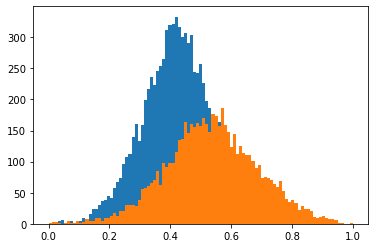

In [38]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.43589398 0.53740144
0.1276057 0.15030402


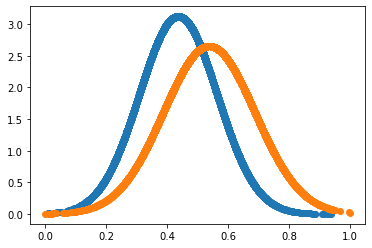

In [39]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

In [40]:
# 에러 발생 확률 (이영빈님 코드 참고)
detect_error = []

for i in range(len(bol_test_labels)):
    if tf.cast(bol_test_labels[i], dtype = tf.int32) != gt_labels[i]:
        detect_error.append(i)
        error_rate = len(detect_error)/len(bol_test_labels)
        
print('에러 발생 확률 : {}'.format(error_rate))

에러 발생 확률 : 0.442


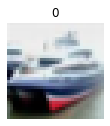

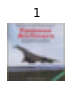

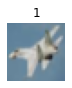

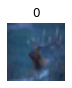

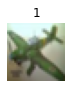

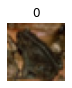

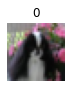

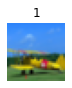

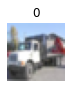

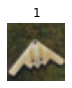

In [42]:
plt.figure(figsize=(10, 5))

for i  in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_data[detect_error[i]], cmap='gray')
    plt.title(gt_labels[detect_error[i]])
    plt.axis('off')
    plt.show()